<a href="https://colab.research.google.com/github/LeaCarop/Serie_temporal/blob/main/Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRIMERA PARTE 

## RED NEURONAL CON **UNA VARIABLE**

In [1]:
# IMPORTAR LIBRERÍAS

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (16, 9) # para personalizar la dimensión de todos los gráficos
plt.style.use('fast') # para crear un estilo personalizado

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler

In [2]:
# CARGAR ARCHIVO CSV CON LOS DATOS

url = "https://raw.githubusercontent.com/jbagnato/machine-learning/master/time_series.csv"
df = pd.read_csv(url, parse_dates=[0], header=None, index_col=0, squeeze=True, names=['fecha','unidades'])
df.head()

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
Name: unidades, dtype: int64

### PRONÓSTICO DE VENTAS DIARIAS CON RED NEURONAL

In [3]:
PASOS=7

# convertir series en aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia de pronóstico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # poner todo junto
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # eliminar filas con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargar datos
values = df.values
# asegúrese de que todos los datos sean flotantes
values = values.astype('float32')
# normalizar variable
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# enmarcar como aprendizaje supervisado
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()


,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


In [4]:
# DIVIDIR DATASET EN TRAIN Y TEST

values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


In [5]:
# ARQUITECTURA DE LA RED NEURONAL
   # agrego capa oculta con 4 neuronas
   # cambio de oprimizador Adam a Nadam

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(4, input_shape=(1,PASOS),activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='Nadam', metrics=["mse"])
    model.summary()
    return model

En esta primera arquitectura de red neuronal he realizado algunos cambios en comparación a la que veíamos en la Parte 1:
* Agrego capa oculta con 4 neuronas, manteniendo igual input_shape y la función de activación (la razón principal de mantenerla es porque los valores se están escalando entre -1 y 1. Usar otra función de activación significa que todos los valores inferiores a 0 los tiene en cuenta como 0).
* Cambio de optimizador de Adam a **Nadam**. Es muy parecido a Adam pero converge mejor. 

In [6]:
# ENTRENAMIENTO
  # mantengo número de épocas

EPOCHS=40
 
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 7)              56        
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 32        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
81/81 [==============================] - 1s 5ms/step - loss: 0.2102 - mse: 0.0763 - val_loss: 0.1591 - val_mse: 0.0407
Epoch 2/40
81/81 [==============================] - 0s 2ms/ste

Manteniendo el mismo número de épocas vemos como logramos bajar levemente los valores de loss y mse.

In [13]:
# ENTRENAMIENTO
  # aumento el número de épocas

EPOCHS=60
 
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1, 7)              56        
                                                                 
 flatten_3 (Flatten)         (None, 7)                 0         
                                                                 
 dense_10 (Dense)            (None, 4)                 32        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
81/81 [==============================] - 1s 4ms/step - loss: 0.2741 - mse: 0.1253 - val_loss: 0.2114 - val_mse: 0.0776
Epoch 2/60
81/81 [==============================] - 0s 2ms/s

Si añado más epocas logro disminuir aún más los valores de loss y mse, pero aún no son inferiores a la red neuronal con múltiples variables. 

Probaré nuevamente con la misma arquitectura pero cambiando el optimizador. He usado **SGD, AdaGrad y AdaMax** pero el que ofrece unos valores más bajos es **RMSProp.** Sin embargo, este modelo tiene mucho overfitting, por lo que seguiré trabajando con el anterior. 

In [8]:
# ARQUITECTURA DE LA RED NEURONAL
  # mantengo la nueva capa oculta
  # uso optimizador RMSprop

def crear_modeloFF():
    model1 = Sequential() 
    model1.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model1.add(Flatten())
    model1.add(Dense(4, input_shape=(1,PASOS),activation='tanh'))
    model1.add(Dense(1, activation='tanh'))
    model1.compile(loss='mean_absolute_error', optimizer='RMSprop', metrics=["mse"])
    model1.summary()
    return model1

In [9]:
# ENTRENAMIENTO

EPOCHS=60
 
model1 = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1, 7)              56        
                                                                 
 flatten_2 (Flatten)         (None, 7)                 0         
                                                                 
 dense_7 (Dense)             (None, 4)                 32        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
81/81 [==============================] - 0s 3ms/step - loss: 0.1592 - mse: 0.0479 - val_loss: 0.1461 - val_mse: 0.0362
Epoch 2/60
81/81 [==============================] - 0s 4ms/s

Representándolo gráficamente este modelo comete mucho overfitting.

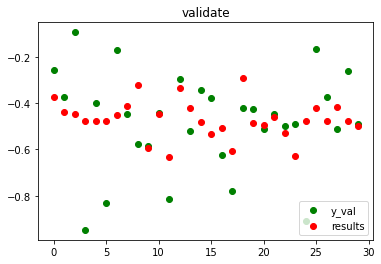

In [14]:
# PREDICCIÓN

results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g', label= 'y_val')
plt.scatter(range(len(results)),results,c='r', label = 'results')
plt.title('validate')
plt.legend(loc="lower right")
plt.show()

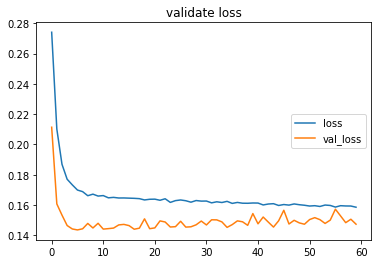

In [15]:
plt.plot(history.history['loss'], label = 'loss')
plt.title('loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('validate loss')
plt.legend(loc="right")
plt.show()

## SEGUNDA PARTE

### RED NEURONAL CON **MÚLTIPLES VARIABLES**

In [24]:
url = "https://raw.githubusercontent.com/jbagnato/machine-learning/master/time_series.csv"
df = pd.read_csv(url, parse_dates=[0], header=None, index_col=0, names=['fecha','unidades'])

# CARGAR DATOS CATEGÓRICOS 

df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2017-01-02,236,0,1
2017-01-03,237,1,1
2017-01-04,290,2,1
2017-01-05,221,3,1
2017-01-07,128,5,1


In [25]:
# PROCESADO DE DATOS

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [26]:
PASOS=7

# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('unidades',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.0,1.0,-0.314815,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,...,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2,1,-0.433333
2017-01-12,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,...,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3,1,-0.607407
2017-01-13,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,...,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4,1,-0.522222
2017-01-14,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,...,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5,1,-0.644444
2017-01-16,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,...,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444,0,1,-0.344444


In [27]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)  # se eliminan las variables var1 y var2
print(newReframed.shape)
newReframed.head()

(597, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.0,1.0,-0.314815,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,...,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,-0.433333
2017-01-12,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,...,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,-0.607407
2017-01-13,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,...,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,-0.522222
2017-01-14,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,...,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,-0.644444
2017-01-16,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,...,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444,-0.344444


In [28]:
# DIVIDIR EN TRAIN Y TEST

values = newReframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 21) (567,) (30, 1, 21) (30,)


In [29]:
# ARQUITECTURA DE LA RED NEURONAL
  # mantener nueva capa oculta
  # usar optimizador Nadam

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh')) # se multiplica el número de pasos anteriores (7) por 3 (total de variables que se usa ahora)
    model.add(Flatten())
    model.add(Dense(4, input_shape=(1,PASOS*3),activation='tanh')) 
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Nadam',metrics=["mse"])
    model.summary()
    return model

In [30]:
EPOCHS=60

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1, 7)              154       
                                                                 
 flatten_4 (Flatten)         (None, 7)                 0         
                                                                 
 dense_13 (Dense)            (None, 4)                 32        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
81/81 [==============================] - 1s 4ms/step - loss: 0.2690 - mse: 0.1257 - val_loss: 0.1620 - val_mse: 0.0478
Epoch 2/60
81/81 [==============================] - 0s 2ms

In [31]:
# ARQUITECTURA DE LA RED NEURONAL
  # aumentar neuronas de la capa oculta (de 4 a 6)
  # usar optimizador RMSprop

def crear_modeloFF():
    model1 = Sequential() 
    model1.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh')) # se multiplica el número de pasos anteriores (7) por 3 (total de variables que se usa ahora)
    model1.add(Flatten())
    model1.add(Dense(6, input_shape=(1,PASOS*3),activation='tanh'))
    model1.add(Dense(1, activation='tanh'))
    model1.compile(loss='mean_absolute_error', optimizer='RMSprop', metrics=["mse"])
    model1.summary()
    return model1

In [32]:
EPOCHS=50

model1 = crear_modeloFF()

history=model1.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1, 7)              154       
                                                                 
 flatten_5 (Flatten)         (None, 7)                 0         
                                                                 
 dense_16 (Dense)            (None, 6)                 48        
                                                                 
 dense_17 (Dense)            (None, 1)                 7         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
81/81 [==============================] - 3s 14ms/step - loss: 0.5078 - mse: 0.4202 - val_loss: 0.1817 - val_mse: 0.0537
Epoch 2/50
81/81 [==============================] - 0s 4m

In [33]:
# ARQUITECTURA DE LA RED NEURONAL
  # usar optmizador Adam
  # mantener nuevo número de neuronas (6)

def crear_modeloFF():
    model2 = Sequential() 
    model2.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh')) # se multiplica el número de pasos anteriores (7) por 3 (total de variables que se usa ahora)
    model2.add(Flatten())
    model2.add(Dense(6, input_shape=(1,PASOS*3),activation='tanh'))
    model2.add(Dense(1, activation='tanh'))
    model2.compile(loss='mean_absolute_error', optimizer='Adam', metrics=["mse"])
    model2.summary()
    return model2

In [34]:
EPOCHS=60

model2 = crear_modeloFF()

history=model2.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1, 7)              154       
                                                                 
 flatten_6 (Flatten)         (None, 7)                 0         
                                                                 
 dense_19 (Dense)            (None, 6)                 48        
                                                                 
 dense_20 (Dense)            (None, 1)                 7         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
81/81 [==============================] - 2s 8ms/step - loss: 0.3146 - mse: 0.1740 - val_loss: 0.2014 - val_mse: 0.0711
Epoch 2/60
81/81 [==============================] - 0s 4ms

Los resultados de esta red son menores a la anterior, incluso inferiores a la del ejercicio original (0.1514). El modelo de serie temporal de 1 variable y este (múltiples variables) comienzan a distar cuando se aplica cambios en el número de neuronas (paso de 4 a 6 y mantengo optimizador).

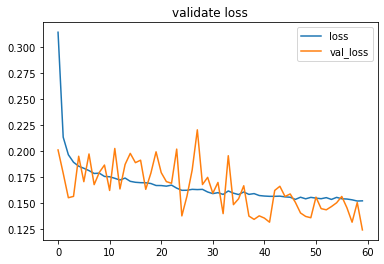

In [35]:
plt.plot(history.history['loss'], label = 'loss')
plt.title('loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('validate loss')
plt.legend(loc='upper right')
plt.show()

Al igual que en la Parte 1 la curva de validación sigue siendo algo errática, pero se ha conseguido bajar los valores de loss, de 0.1514 a 0.1480 y mse de 0.0527 a 0.0499.

# TERCERA PARTE 

## RED NEURONAL CON **EMBEDDINGS**

In [38]:
# NUEVAS LIBRERÍAS

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model


url = "https://raw.githubusercontent.com/jbagnato/machine-learning/master/time_series.csv"
df = pd.read_csv(url, parse_dates=[0], header=None, index_col=0, names=['fecha','unidades'])

df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2017-01-02,236,0,1
2017-01-03,237,1,1
2017-01-04,290,2,1
2017-01-05,221,3,1
2017-01-07,128,5,1


In [39]:
# PROCESADO DE LOS DATOS

PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [40]:
# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    contador=contador+1
reframed.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,3.0,1.0
1,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,4.0,1.0
2,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,5.0,1.0
3,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,0.0,1.0
4,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444,1.0,1.0


In [41]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,3.0,1.0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
1,4.0,1.0,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
2,5.0,1.0,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
3,0.0,1.0,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
4,1.0,1.0,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444
...,...,...,...,...,...,...,...,...,...,...
591,0.0,11.0,-0.777778,-0.422222,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407
592,1.0,11.0,-0.422222,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667
593,2.0,11.0,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667,-0.374074
594,3.0,11.0,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667,-0.374074,-0.511111


In [42]:
# DIVIDIR EN TRAIN Y TEST

training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[595-30:595]
valid_target=target_data[595-30:595]

training_data = training_data[0:595]
target_data=target_data[0:595]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(595, 9) (595,) (30, 9) (30,)


In [44]:
# ARQUITECTURA DE RED NEURONAL
  # añadir capa oculta con 4 neuronas


def crear_modeloEmbeddings():
    emb_dias = 2 #tamaño profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    x = Dense(4,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [45]:
#ENTRENAMIENTO 

EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 2)         16          ['dias[0][0]']                   
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 4)         52          ['meses[0][0]']                  
                                                                                              

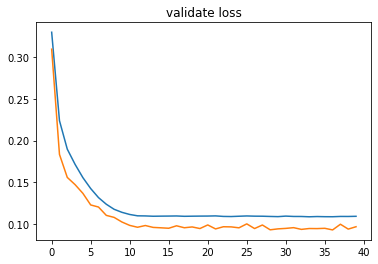

In [46]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [47]:
#ENTRENAMIENTO 

EPOCHS=60

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 2)         16          ['dias[0][0]']                   
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 4)         52          ['meses[0][0]']                  
                                                                                            

Logra una mejora considerable en comparación a las anteriores, pero este primer modelo no consigue bajar más que el original. La ides es conseguir un loss inferior a 0.1080. Sin embargo, aumentar el número de épocas a 60 permite que alcanzar un loss de 0.1081.

In [71]:
# ARQUITECTURA DE RED NEURONAL
  # añadir capa oculta con 4 neuronas
  # añadir segunda capa de flatten
  # usar optimizador Adam


def crear_modeloEmbeddings():
    emb_dias = 2 #tamaño profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    x = Flatten()(x)
    x = Dense(6,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [73]:
#ENTRENAMIENTO 

EPOCHS=80

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 1, 2)         16          ['dias[0][0]']                   
                                                                                                  
 embedding_31 (Embedding)       (None, 1, 4)         52          ['meses[0][0]']                  
                                                                                           

He probado con el cambio de varios parámetros pero no logro mejorar el rendimiento del origunal. Al menos tampoco empeorarlo, ¡no es mala señal!